In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-news-engagement-on-social-media/cnn.csv
/kaggle/input/global-news-engagement-on-social-media/bbc.csv
/kaggle/input/global-news-engagement-on-social-media/al_jazeera.csv
/kaggle/input/global-news-engagement-on-social-media/reuters.csv


# LOADING DATA

In [2]:
import warnings
df=pd.read_csv('/kaggle/input/global-news-engagement-on-social-media/bbc.csv')
df.head()

,text,likes,comments,shares
0,Queen Camilla was given a miniature version of...,577,228,50
1,"The study found females of five ""menopausal"" w...",174,18,52
2,The Ivy League university is named after Elihu...,116,59,44
3,"When the law passed in 2019, it sparked mass p...",133,56,16
4,"Freedom Village is located inside Korea's DMZ,...",117,18,26


In [3]:
df.shape

(1000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      1000 non-null   object
 1   likes     1000 non-null   int64 
 2   comments  1000 non-null   int64 
 3   shares    1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


In [5]:
df.isna().sum()

text        0
likes       0
comments    0
shares      0
dtype: int64

# ANALYZING TEXT COLUMN

In [6]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from collections import Counter

In [7]:
# Tokenize the text column into sentences
df['sentences'] = df['text'].apply(sent_tokenize)

In [8]:
# Tokenize the sentences into words
df['words'] = df['sentences'].apply(lambda x: [word_tokenize(sent) for sent in x])

In [9]:
import string
# Remove punctuation marks
punctuations = string.punctuation
df['words_no_punct'] = df['words'].apply(lambda x: [[word.translate(str.maketrans('', '', string.punctuation)) for word in sent] for sent in x])

In [10]:
# Remove stop words
stop_words = set(stopwords.words('english'))
df['words_cleaned'] = df['words_no_punct'].apply(lambda x: [[word for word in sent if word.lower() not in stop_words] for sent in x])

In [11]:
# Stem the words
stemmer = PorterStemmer()
df['words_stemmed'] = df['words_cleaned'].apply(lambda x: [[stemmer.stem(word) for word in sent] for sent in x])

In [12]:
# Flatten the list of lists
df['words_flat'] = df['words_stemmed'].apply(lambda x: [item for sublist in x for item in sublist])

In [13]:
# Count word frequencies
word_counts = Counter()
for words in df['words_flat']:
    word_counts.update(words)

In [14]:
# Print the most common words
print("Most common words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

Most common words:
: 2569
said: 110
year: 56
peopl: 52
bbc: 48
one: 45
via: 43
US: 41
nt: 34
would: 31


# ANALYZING SENTIEMNT SCORE

In [15]:
from nltk.sentiment import SentimentIntensityAnalyzer
# Initialize the sentiment analyzer
sid = SentimentIntensityAnalyzer()

/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [16]:
# Function to calculate sentiment scores
def calculate_sentiment(text):
    scores = sid.polarity_scores(text)
    return scores['compound']

In [17]:
# Apply the sentiment analysis function to the 'text' column
df['sentiment_score'] = df['text'].apply(calculate_sentiment)

# Print the sentiment scores
print(df[['text', 'sentiment_score']])

                                                  text  sentiment_score
0    Queen Camilla was given a miniature version of...           0.0000
1    The study found females of five "menopausal" w...           0.0000
2    The Ivy League university is named after Elihu...           0.0000
3    When the law passed in 2019, it sparked mass p...          -0.8350
4    Freedom Village is located inside Korea's DMZ,...           0.6369
..                                                 ...              ...
995  The animals were discovered in small film cani...          -0.3400
996           George Freeman had a salary of £118,300.           0.4019
997  Valdo Calocane admitted manslaughter on the gr...          -0.5859
998  The US blamed Iranian-backed groups and said t...          -0.7351
999  "We've probably got more hedgerows in England ...           0.0000

[1000 rows x 2 columns]


In [18]:
import matplotlib.pyplot as plt

In [19]:
# Categorize sentiment scores into positive, neutral, and negative
bins = [-1, -0.05, 0.05, 1]
labels = ['Negative', 'Neutral', 'Positive']
df['sentiment_category'] = pd.cut(df['sentiment_score'], bins=bins, labels=labels)

In [20]:
# Count the occurrences of each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

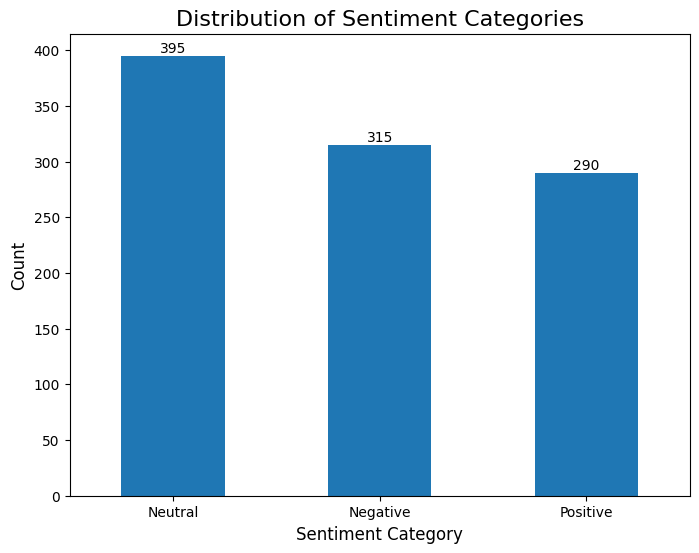

In [21]:
# Create a bar plot
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar')
plt.xlabel('Sentiment Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Sentiment Categories', fontsize=16)
plt.xticks(rotation=0)

# Add value labels on top of the bars
for i, v in enumerate(sentiment_counts.values):
    plt.text(i, v, str(v), fontsize=10, horizontalalignment='center', verticalalignment='bottom')

plt.show()

This distribution suggests that a significant portion of the text in the dataset has been classified as having neutral sentiment, meaning that the content does not express strong positive or negative emotions or opinions.

The "Negative" sentiment category having the second-highest count indicates that there is a considerable amount of text expressing negative sentiments, such as criticism, dissatisfaction, or undesirable opinions.

The "Positive" sentiment category has the lowest count, implying that the dataset contains relatively fewer instances of text expressing positive sentiments, such as praise, joy, or favorable opinions.

# ANALYZING ENGAGEMENT LEVELS

In [22]:
# Overall Engagement Levels
print("Overall Engagement Levels:")
print("Total Likes:", df['likes'].sum())
print("Total Comments:", df['comments'].sum())
print("Total Shares:", df['shares'].sum())

Overall Engagement Levels:
Total Likes: 805666
Total Comments: 246535
Total Shares: 67735


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


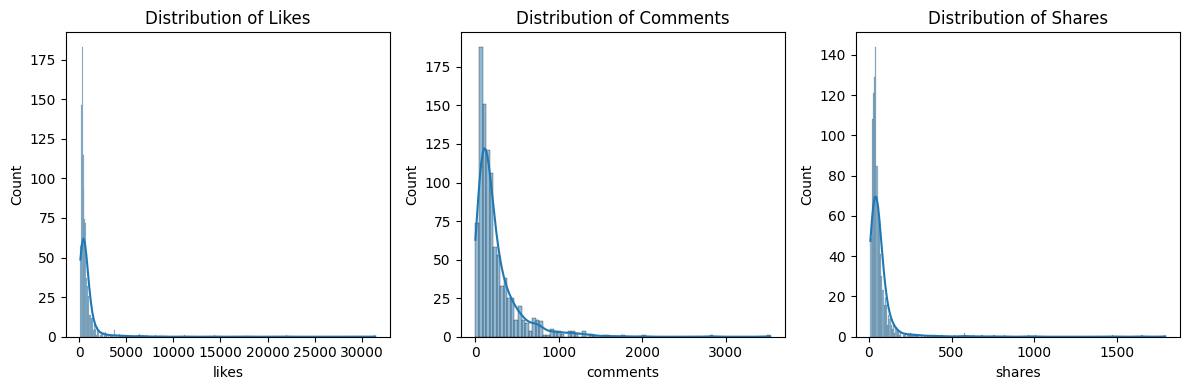

In [23]:
import seaborn as sns
# Engagement Distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
sns.histplot(df['likes'], kde=True)
plt.title('Distribution of Likes')

plt.subplot(1, 3, 2)
sns.histplot(df['comments'], kde=True)
plt.title('Distribution of Comments')

plt.subplot(1, 3, 3)
sns.histplot(df['shares'], kde=True)
plt.title('Distribution of Shares')

plt.tight_layout()
plt.show()


These distributions suggest that while the majority of content pieces receive relatively moderate levels of engagement (likes, comments, shares), there are a few outliers or highly engaging content pieces that drive the long tails in the distributions, particularly for likes.

The heavily skewed nature of the distributions, especially for likes, could be due to several factors, such as the presence of viral or highly popular content pieces, the influence of influential accounts or content creators, or the specific dynamics of engagement on the platform or social network being analyzed.

In [24]:
# Correlation Analysis
engagement_corr = df[['likes', 'comments', 'shares']].corr()
print("\nCorrelation Matrix:")
print(engagement_corr)


Correlation Matrix:
             likes  comments    shares
likes     1.000000  0.365673  0.667817
comments  0.365673  1.000000  0.386269
shares    0.667817  0.386269  1.000000


The correlation coefficient between likes and comments is 0.365673, which indicates a moderate positive correlation. This means that content with more likes tends to have more comments as well, but the relationship is not extremely strong.

The correlation coefficient between likes and shares is 0.667817, which indicates a moderately strong positive correlation. This suggests that content with more likes is likely to have a higher number of shares as well, and vice versa.

The correlation coefficient between comments and shares is 0.386269, which is a moderate positive correlation. This implies that content with more comments tends to have more shares as well, but the relationship is not as strong as the one between likes and shares.

In [25]:
# Engagement by Sentiment
sentiment_engagement = df.groupby('sentiment_category')[['likes', 'comments', 'shares']].sum().reset_index()
print("\nEngagement by Sentiment:")
print(sentiment_engagement)


Engagement by Sentiment:
  sentiment_category   likes  comments  shares
0           Negative  221351     86017   20955
1            Neutral  295069     94399   24885
2           Positive  289246     66119   21895


/tmp/ipykernel_18/3910728675.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sentiment_engagement = df.groupby('sentiment_category')[['likes', 'comments', 'shares']].sum().reset_index()


The audience's engagement preferences may vary depending on the sentiment of the content. Neutral content seems to perform well across all engagement metrics, while negative content generates more comments (potentially discussions or reactions), and positive content is well-liked but may not trigger as much sharing or commenting behavior.

In [26]:
# Engagement Ratios by Sentiment
engagement_ratios_by_sentiment = df.groupby('sentiment_category')[['likes', 'comments', 'shares']].sum().reset_index()
engagement_ratios_by_sentiment['comments_to_likes'] = engagement_ratios_by_sentiment['comments'] / engagement_ratios_by_sentiment['likes']
engagement_ratios_by_sentiment['shares_to_likes'] = engagement_ratios_by_sentiment['shares'] / engagement_ratios_by_sentiment['likes']

/tmp/ipykernel_18/1636423700.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  engagement_ratios_by_sentiment = df.groupby('sentiment_category')[['likes', 'comments', 'shares']].sum().reset_index()


In [27]:
print("\nEngagement Ratios by Sentiment:")
print(engagement_ratios_by_sentiment[['sentiment_category', 'comments_to_likes', 'shares_to_likes']])


Engagement Ratios by Sentiment:
  sentiment_category  comments_to_likes  shares_to_likes
0           Negative           0.388600         0.094669
1            Neutral           0.319922         0.084336
2           Positive           0.228591         0.075697


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


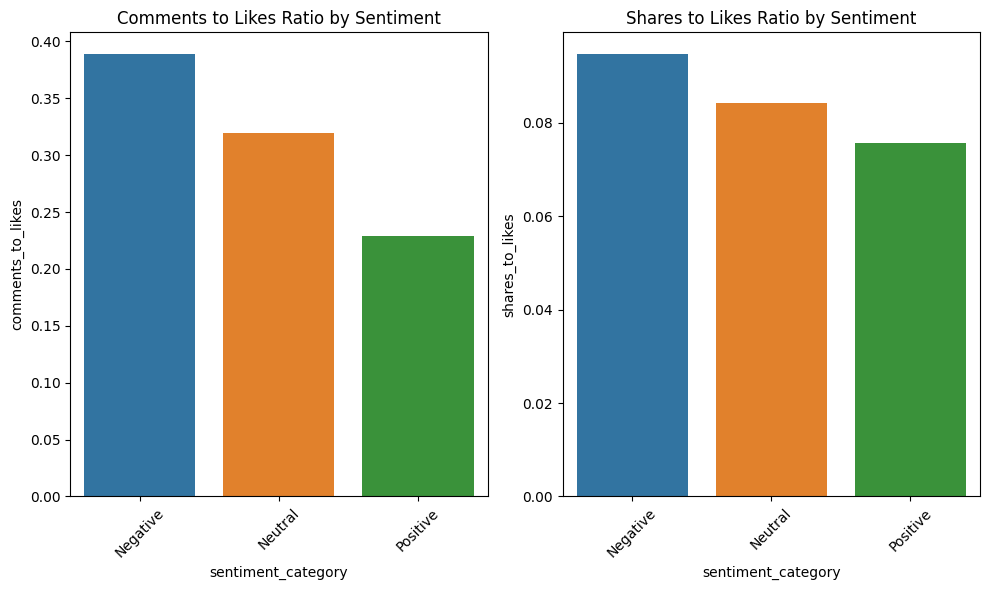

In [28]:
# Visualize Engagement Ratios by Sentiment
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='sentiment_category', y='comments_to_likes', data=engagement_ratios_by_sentiment)
plt.title('Comments to Likes Ratio by Sentiment')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='sentiment_category', y='shares_to_likes', data=engagement_ratios_by_sentiment)
plt.title('Shares to Likes Ratio by Sentiment')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

The ratios indicate that the sentiment of the content has a significant impact on user engagement behaviors. For example:

* Negative sentiment tends to provoke more comments compared to positive or neutral sentiment. This could be because negative content often elicits strong emotional reactions or prompts users to express their opinions or concerns.

* Positive sentiment, while still generating engagement, may result in fewer comments and shares compared to negative sentiment. This suggests that positive content might be more likely to be passively consumed or enjoyed without necessarily prompting extensive discussion or sharing.

* Neutral sentiment falls between negative and positive sentiment in terms of engagement metrics, indicating a moderate level of interaction from users.